<a href="https://colab.research.google.com/github/VimalKandrical/dl_sound_class/blob/Christian/MLP_3_layers_crossvalidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classification of Environmental Sound
**Autoren:**<br> Vimal Kandrical, Christian von Rotz

**Daten:**<br>[Urbansound8k](https://www.kaggle.com/chrisfilo/urbansound8k) 

# Einleitung

Im Rahmen des Moduls Deep Learning im CAS Machine Intelligence werden in diesem Projekt Tonaufnahmen von Umgebungsgeräuschen analysiert und mittels Deep Learning klassifiziert.  

##Beschreibung der Daten (kaggle.com)

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music. The classes are drawn from the urban sound taxonomy. For a detailed description of the dataset and how it was compiled please refer to our paper.
All excerpts are taken from field recordings uploaded to www.freesound.org. The files are pre-sorted into ten folds (folders named fold1-fold10) to help in the reproduction of and comparison with the automatic classification results reported in the article above.

In addition to the sound excerpts, a CSV file containing metadata about each excerpt is also provided.

**Audiofiles:**

8732 audio files of urban sounds (see description above) in WAV format. The sampling rate, bit depth, and number of channels are the same as those of the original file uploaded to Freesound (and hence may vary from file to file).

**Metadaten:**
*   slicefilename:<br>
    The name of the audio file. The name takes the following format:<br><br> [fsID]-4s[classID]-[occurrenceID]-[sliceID].wav<br><br>
    
    [fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
   <br> [classID] = a numeric identifier of the sound class (see description of classID below for further details)
   <br> [occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
   <br> [sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence
*   fsID:<br>
The Freesound ID of the recording from which this excerpt (slice) is taken
*   start:<br>
The start time of the slice in the original Freesound recording
*   end:<br>
The end time of slice in the original Freesound recording
*   salience:<br>
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.
*   fold:<br>
The fold number (1-10) to which this file has been allocated.
*   classID:<br>
A numeric identifier of the sound class:
    0 = airconditioner 1 = carhorn
    2 = childrenplaying 3 = dogbark
    4 = drilling
    5 = engineidling 6 = gunshot
    7 = jackhammer
    8 = siren
    9 = street_music
*   class:<br>
 The class name: airconditioner, carhorn, childrenplaying, dogbark, drilling, engineidling, gunshot, jackhammer,
    siren, street_music.

**Bemerkungen:**<br>
Auf kaggle wird explizit darauf hingewiesen, dass man die Daten nicht noch einmal mischen soll, sondern die vordefinierten 10 folds benützen soll. Nur so kann das erzielte Resultat mit anderen Resultaten verglichen. Zudem soll 10-fold cross validation angewendet werden, da die einzelnen folds nicht gleich schwer sind. Das Endresultat ist die durchschnittliche accuracy. 

# Daten laden

*Dieser Teil muss nur einmal ausgeführt werden, damit die Daten in Colab sind.*

Google Colab benötigt Zugriff auf Kaggle via API. Der API Token muss unter content abliegen.

In [0]:
from google.colab import drive
import os
os.chdir("/content")
os.listdir()

['.config', 'kaggle.json', 'sample_data']

Zugriffsrechte anpassen und File downloaden

In [0]:
!mkdir -p ~/.kaggle
!cp "/content/kaggle.json" ~/.kaggle/
!chmod 600 "/content/kaggle.json"
!kaggle datasets download -d chrisfilo/urbansound8k

100% 5.60G/5.61G [02:06<00:00, 40.0MB/s]
100% 5.61G/5.61G [02:06<00:00, 47.5MB/s]


Zipfile entpacken

In [0]:
os.chdir("/content")
!unzip urbansound8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: fold4/154758-5-0-0.wav  
  inflating: fold4/154758-5-0-1.wav  
  inflating: fold4/154758-5-0-10.wav  
  inflating: fold4/154758-5-0-11.wav  
  inflating: fold4/154758-5-0-12.wav  
  inflating: fold4/154758-5-0-13.wav  
  inflating: fold4/154758-5-0-14.wav  
  inflating: fold4/154758-5-0-15.wav  
  inflating: fold4/154758-5-0-16.wav  
  inflating: fold4/154758-5-0-17.wav  
  inflating: fold4/154758-5-0-18.wav  
  inflating: fold4/154758-5-0-19.wav  
  inflating: fold4/154758-5-0-2.wav  
  inflating: fold4/154758-5-0-20.wav  
  inflating: fold4/154758-5-0-21.wav  
  inflating: fold4/154758-5-0-3.wav  
  inflating: fold4/154758-5-0-4.wav  
  inflating: fold4/154758-5-0-5.wav  
  inflating: fold4/154758-5-0-6.wav  
  inflating: fold4/154758-5-0-7.wav  
  inflating: fold4/154758-5-0-8.wav  
  inflating: fold4/154758-5-0-9.wav  
  inflating: fold4/155320-3-0-0.wav  
  inflating: fold4/156362-4-0-0.wav  
  inflating: fold4/156362

# Voranalyse

Bevor die Audiofiles genutzt werden können, muss ihr Aufbau verstanden werden. Diese Informationen stehen ganz am Anfang des WAV Files im sogenannten Header (44 Bytes lang). Folgende Informationen sind relevant:

Information  | Position
  ------------- | -------------
  Anzahl Channels (mono/stereo)  | 23-24
  Sample rate  | 25-28
Bits pro Sample | 35-36

(Details zum Aufbau eines WAV (RIFF) Files können [hier](http://www.topherlee.com/software/pcm-tut-wavformat.html) nachgelesen werden.)

Hier ein Beispiel:

In [0]:
import struct
import os


def readheader(filename):
  with open(filename, "rb") as wavfile:
    header = wavfile.read(44)
    channels = struct.unpack("<H", header[22:24])[0]
    samplerate = struct.unpack("<I", header[24:28])[0]
    bitsprosample = struct.unpack("<H", header[34:36])[0]
  return (channels, samplerate, bitsprosample)

beispiel = readheader("/content/fold1/101415-3-0-2.wav")
print("Anzahl Channels: ", beispiel[0])
print("Sample rate: ", beispiel[1])
print("Bits pro Sample: ", beispiel[2])

Anzahl Channels:  1
Sample rate:  48000
Bits pro Sample:  16


Zuest lesen wir nun die Klassenzugehörigkeit jedes Audiofiles

In [0]:
import pandas as pd

pd.options.display.max_columns = 10

metadaten = pd.read_csv('/content/UrbanSound8K.csv')
# Anpassung des Header des Dataframes, da class ein reservierter Begriff ist
metadaten = metadaten.rename({'class': 'class_name'}, axis = 'columns')
print('Metadaten header', '\n')
print(metadaten.head()) 
print('\n', 'Datentypen der einzelnen Variablen', '\n')
print(metadaten.dtypes) #-> passt soweit
print('\n', 'Klassenzugehörigkeit', '\n')
print(metadaten.class_name.value_counts())
print('\n')

Metadaten header 

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

         class_name  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  

 Datentypen der einzelnen Variablen 

slice_file_name     object
fsID                 int64
start              float64
end                float64
salience             int64
fold                 int64
classID              int64
class_name          object
dtype: object

 Klassenzugehörigkeit 

children_playing    1000
air_conditioner     1000
dog_bark            1000
drilling            100

Der Datensatz hat keine regelmässige Verteilung auf die Klassen! 

Wir lesen nun analog oben für jedes Audiofiles die Charakteristik und halten diese in einem Dataframe fest.

In [0]:
informationen = []

for i, r in metadaten.iterrows():
  audiofile = os.path.join(os.path.abspath('/content/'), 'fold' + str(r['fold']) + '/', str(r['slice_file_name']))
  informationen.append(readheader(audiofile))

aufbau = pd.DataFrame(informationen, columns=['anz_channels','samplerate','bits_pro_sample'])
print(aufbau["anz_channels"].value_counts(), '\n')
print(aufbau["samplerate"].value_counts(), '\n')
print(aufbau["bits_pro_sample"].value_counts(), '\n')

2    7993
1     739
Name: anz_channels, dtype: int64 

44100     5370
48000     2502
96000      610
24000       82
16000       45
22050       44
11025       39
192000      17
8000        12
11024        7
32000        4
Name: samplerate, dtype: int64 

16    5758
24    2753
32     169
8       43
4        9
Name: bits_pro_sample, dtype: int64 



Es lässt sich festhalten, dass die Audiofiles bzgl. Anzahl Channels (Mono/Stereo), Samplerate und Bits pro Sample variieren.

# Vorbereitung der Daten aufgrund der Voranalyse

Wir haben festgestellt, dass die Datensätze unterschiedliche Ausprägungen in den Daten haben und bezüglich der Datenkonsistenz vorbereitet/angepasst werden müssen. Dazu verwenden wir die <b> Librosa load()</b> Funktion.
<ul>
<li>Anzahl channels: werden auf 1 reduziert</li>
<li>Samplerate: konvertiert alle Samples auf 22.050 KHz</li>
<li>Bits pro sample: wird auf einen range von -1 und 1 normalisiert</li>
</ul>

Anhand eines Beispiel zeigen wir diese Anpassungen auf (als Vergleich der Originaldaten und den Daten mit Librosa eingelesen).

Anzeige der Kanäle 



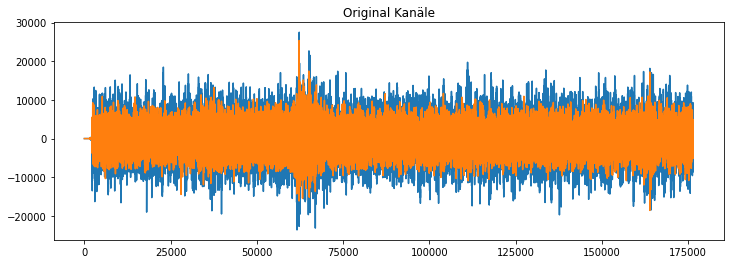

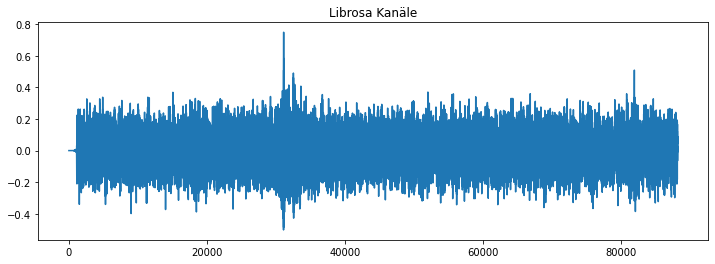


 Anzeige der Samplerate
Original Hz:  44100
Librosa Hz:  22050

 Anzeige der Bits pro sample
Original audio file min~max range:  -23628 to 27507
Librosa audio file min~max range:  -0.50266445 to 0.74983937


In [0]:
import librosa
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import numpy as np

# ein Beispielfilename
beispiel_dateiname = '/content/fold5/100852-0-0-0.wav'
librosa_audio, librosa_sample_rate = librosa.load(beispiel_dateiname)
scipy_sample_rate, scipy_audio = wav.read(beispiel_dateiname)

# Anzahl Kanäle
print('Anzeige der Kanäle', '\n')
plt.figure(figsize = (12, 4))
plt.title('Original Kanäle')
plt.plot(scipy_audio)

plt.figure(figsize = (12, 4))
plt.title('Librosa Kanäle')
plt.plot(librosa_audio)
plt.show()

# Sample rate
print('\n', 'Anzeige der Samplerate')
print('Original Hz: ', scipy_sample_rate)
print('Librosa Hz: ', librosa_sample_rate)

# Bits pro sample
print('\n', 'Anzeige der Bits pro sample')
print('Original audio file min~max range: ', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range: ', np.min(librosa_audio), 'to', np.max(librosa_audio))

# Feature extraction

Wir extrahieren die <b>Mel-Frequency Cepstral Coefficients (MFCC)</b> der jeweiligen Audiofiles zusammen mit deren Klassenzugehörigkeit. Dank diesem Feature können wir sowohl die Frequenz als auch die zeitliche Charakteristik eines Files erkennen.

Mathematisch formuliert wird die Impulsantwort des Filters mit dem Anregungssignal gefaltet, um das Sprachsignal zu erzeugen. Es werden folgende Schritte berechnet:
1. Unterteilung des Eingangssignals in Blöcke (Frames)
2. Fourier-Transformation jedes Fensters
3. Erzeugung des Beitragsspektrum
4. Logarithmierung des Beitragsspektrums
5. Reduktion der Anzahl der Frequenzbänder durch Zusammenfassung (z.B. auf 40)
6. Abschliessende Dekorrelation durch PCA oder Kosinustransformation

In [0]:
mfccs = librosa.feature.mfcc(y = librosa_audio, sr = librosa_sample_rate, n_mfcc = 40)
print(mfccs.shape)

(40, 173)


Für ein einzelnes Audiofile werden also 40 MFCCs über 173 frames erstellt!

Wir extrahieren nun für alle Audiofiles die MFCC

In [0]:
def extract_features(file_name):

  try:
    audio, sample_rate = librosa.load(file_name, res_type = 'kaiser_fast')
    mfccs = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 40)
    mfccsscaled = np.mean(mfccs.T, axis = 0)

  except Exception as e:
    print('Error encountered while parsing audiofile: ', file)
    return None

  return mfccsscaled

# Bibliotheken laden (sollte eigenltich bereits der Fall sein)
import pandas as pd
import os
import librosa

# Metadaten auslesen (sollte eigentlich bereits der Fall sein)
metadaten = pd.read_csv('/content/UrbanSound8K.csv')
# Anpassung des Header des Dataframes, da class ein reservierter Begriff ist
metadaten = metadaten.rename({'class': 'class_name'}, axis = 'columns')

features = []

for each_index, each_row in metadaten.iterrows():
  audiofile = os.path.join(os.path.abspath('/content/'), 'fold' + 
                           str(each_row['fold']) + '/', 
                           str(each_row['slice_file_name']))

  klasse = each_row['class_name']
  fold = each_row['fold']
  daten = extract_features(audiofile)

  features.append([daten, fold, klasse])

featuresdf = pd.DataFrame(features, columns = ['feature', 'fold', 'klasse'])
print('Features aus ', len(featuresdf), ' Dateien extrahieren')

Features aus  8732  Dateien extrahieren


Als nächstes wandeln wir die extrahierten Daten und Klassenbezeichnungen in vom Model verwertebare numerische Daten um (sklearn.preprocessing.LabelEncoder)

In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# wandelt die extrahierten Features und Klassenbezeichnungen in numpy arrays um
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.klasse.tolist())

# Neukodierung der Klassenbezeichnungen (von kategoriell zu numerisch)
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))


Using TensorFlow backend.


# Aufteilung der Daten in Trainings- und Testdaten

Ziel ist es, dass Model/Netzwerk auf den Trainingsdaten zu trainieren und zum Schluss auf den Testdaten zu testen.
Wir nehmen 20% Testdaten, lernen also auf 80% der Daten (kann als Variable einfach geändert werden)

In [0]:
from sklearn.model_selection import train_test_split

test_size = 0.2 # 20% Testdaten
random_state = 42 # random_state as the name suggests, is used for initializing the internal random number generator, 
                  # which will decide the splitting of data into train and test indices in your case.
                  # If random_state is None or np. random, then a randomly-initialized RandomState object is returned.
                  
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size = test_size, random_state = random_state)
print(x_train.shape)

(6985, 40)


Aufgrund obiger Codezeilen, können nun verschiedene Modelle erstellt werden
x_train, y_train
x_test, y_test

sind die Input-Variablen für die Modelle

# Modelimplementation - Multilayer Perceptron (MLP) Neural Network mit Keras und Tensorflow

<b>Model Architektur (Dense, 3 Layers, 256 Knoten, 100 Epochen, Batch_size 32</b>
<br> Art: Seqential (Layer bei Layer)
<br> Anzahl Layers: 3
<br> Type: Dense
<br> Anzahl Knoten: 256
<br> <br> Layer 1: 40 Input / 
Hidden layer: 40 x 256 (output) /
Aktivierung: relu /
Dropout rate: 50%
<br> Layer 2: 256 Input /
Hidden layer: 256 x 256 (output) /
Aktivierung: relu /
Dropout rate: 50%
<br> Layer 3: 256 Input (Output layer) /
Hidden layer: 256 x 10 (output) /
Aktivierung: softmax

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical 
from sklearn import metrics

num_labels = yy.shape[1]
filter_size = 2
initial_input = 40
output1 = 256
output2 = 256
dropout_rate = 0.5

# Erstellen des Models
model = Sequential()

model.add(Dense(output1, batch_input_shape = (None, initial_input)))
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(output1))
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

<b> Modell kompilieren</b><br>
Loss function: categorical_crossentropy
<br> Metrics: aktiviert, um laufend den Score zu sehen
<br> Optimizer: adam

In [0]:
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

model.summary()

# Berechnung der 'Pre-Trainings' Genauigkeit
score = model.evaluate(x_test, y_test, verbose = 0)
accuracy = 100 * score[1]
print('Pre-training accuracy: %.4f%%' % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2

<b> Modell trainieren</b><br>
Anzahl Epochen: 100 -> wie häufig das Model durch die Daten looped
<br> batch size: 32 -> je grösser, desto schlechter Generalisiert das Model (overfitting)

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

start = datetime.now()

history = model.fit(x_train, 
                    y_train, 
                    batch_size = num_batch_size, 
                    epochs = num_epochs, 
                    validation_data = (x_test, y_test))

duration = datetime.now() - start
print('Training completed in time: ', duration)

Epoch 1/100
219/219 [==============================] - 1s 3ms/step - loss: 7.9641 - accuracy: 0.1948 - val_loss: 2.1203 - val_accuracy: 0.2570
Epoch 2/100
219/219 [==============================] - 1s 3ms/step - loss: 2.2419 - accuracy: 0.2541 - val_loss: 1.9979 - val_accuracy: 0.3102
Epoch 3/100
219/219 [==============================] - 1s 3ms/step - loss: 2.0317 - accuracy: 0.2856 - val_loss: 1.8337 - val_accuracy: 0.3755
Epoch 4/100
219/219 [==============================] - 1s 3ms/step - loss: 1.8817 - accuracy: 0.3457 - val_loss: 1.6453 - val_accuracy: 0.4471
Epoch 5/100
219/219 [==============================] - 1s 3ms/step - loss: 1.7412 - accuracy: 0.3848 - val_loss: 1.5103 - val_accuracy: 0.5020
Epoch 6/100
219/219 [==============================] - 1s 3ms/step - loss: 1.6227 - accuracy: 0.4351 - val_loss: 1.4173 - val_accuracy: 0.5558
Epoch 7/100
219/219 [==============================] - 1s 3ms/step - loss: 1.5305 - accuracy: 0.4727 - val_loss: 1.2835 - val_accuracy: 0.5902

<b> Modell testen</b><br>
Dabei vergleichen wir die Genauigkeit zwischen den Trainings- und Testdaten, um die Generalisierung des Modells zu überprüfen (kein Overfitting)

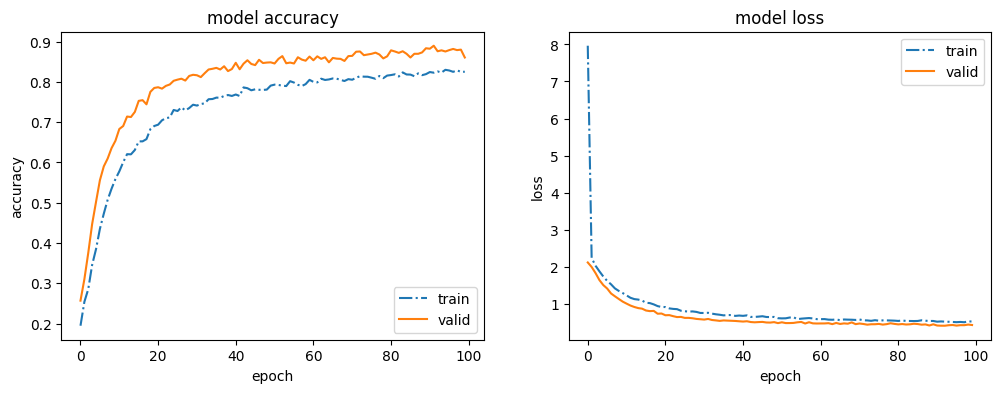

In [0]:
# Anzeige der Entwicklung der Genauigkeit und Loss-function
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, (1))
plt.plot(history.history['accuracy'], linestyle = '-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'lower right')
plt.subplot(1, 2, (2))
plt.plot(history.history['loss'], linestyle = '-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper right')
plt.show()

In [0]:
score_train = model.evaluate(x_train, y_train, verbose = 0)
print('Trainigsgenauigkeit: ', score_train[1])

score_test = model.evaluate(x_test, y_test, verbose = 0)
print('Testgenauigkeit: ', score_test[1])

print('Differenz des Models: ', score_train[1] - score_test[1])

Trainigsgenauigkeit:  0.9314244985580444
Testgenauigkeit:  0.8603320121765137
Differenz des Models:  0.07109248638153076


Mit diesem Multilayer Perceptron Neural Network ist der Score bereits sehr hoch (gegen 90% Genauigkeit)! Da der Unterschied zwischen der Genauigkeit der Klassifizeriung der Trainings- und der Testdaten um die 5% ist, zeigt das Modell kein Overfitting an.
Zusätzlich zeigen wir die Genuigkeit noch anhand einer Confusion_Matrix auf

In [0]:
def plot_confusion(title, true_labels, predicted_labels, normalized = True):
    labels = list(set(true_labels) | set(predicted_labels))

    if normalized:
        cm = confusion_matrix(true_labels, predicted_labels, labels = labels)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm = confusion_matrix(true_labels, predicted_labels, labels = labels)

    fig, ax = plt.subplots(figsize = (10, 10))
    ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
    ax.set_title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(labels))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(labels, rotation = 90)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(labels)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.grid(False)
    return fig, ax 

plot_confusion(title = 'Confusion matrix, without normalization', normalized = False, true_labels = y_test, predicted_labels = y_test)

TypeError: ignored

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

print(type(y_predict))
print(y_predict.shape)
y_predict_list = np.array(y_predict).ravel()
print(y_predict_list)
print(y_predict_list.shape)
print(y_test.shape)
y_test_list = np.array(y_test).ravel()
print(y_test_list)
print(y_test_list.shape)
print(metadaten.class_name.shape)
labels = np.unique(metadaten.class_name)
print(labels)

y_predict = model.predict(x_test)

cm = confusion_matrix(y_test_list, y_predict_list)

<class 'numpy.ndarray'>
(1747, 10)
[5.3075925e-02 2.2027249e-02 3.6832366e-02 ... 8.1868750e-15 9.9991691e-01
 1.3930929e-08]
(17470,)
(1747, 10)
[0. 0. 0. ... 0. 1. 0.]
(17470,)
(8732,)
['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']


ValueError: ignored

In [0]:
titles_options = [('Confusion matrix, without normalization', None), ('Normalized confusion matrix', 'true')]
for title, normalize in titles_options:
  disp = plot_confusion_matrix(y_predict,
                               x_test, 
                               y_test, 
                               display_labels = metadaten.class_name, 
                               cmap = plt.cm.Blues, normalize = normalize)
  disp.ax_.set_title(title)
  print(title)
  print(disp.confusion_matrix)

plt.show()

<b>Model Architektur (Dense, 4 Layers, 128/256 Knoten, 150 Epochen, Batch_size 8</b><br>
Art: Seqential (Layer bei Layer)<br>
Anzahl Layers: 45<br>
Type: Dense<br>
Anzahl Knoten: 128/256<br>


Layer 1: 40 Input / Hidden layer: 40 x 256 (output) / Aktivierung: relu / Dropout rate: 50%<br>
Layer 2: 256 Input / Hidden layer: 256 x 256 (output) / Aktivierung: relu / Dropout rate: 50%<br>
Layer 3: 256 Input / Hidden layer: 256 x 512 (output) / Aktivierung: relu / Dropout rate: 50%<br>
Aktivierung: softmax


In [0]:
num_labels = yy.shape[1]
initial_input = 40
output1 = 128
output2 = 256
dropout_rate = 0.4

# Erstellen des Models
model2 = Sequential()

model2.add(Dense(output2, batch_input_shape = (None, initial_input)))
model2.add(Activation('relu'))
model2.add(Dropout(dropout_rate))

model2.add(Dense(output2))
model2.add(Activation('relu'))
model2.add(Dropout(dropout_rate))

#model2.add(Dense(output1))
#model2.add(Activation('relu'))
#model2.add(Dropout(dropout_rate))

model2.add(Dense(num_labels))
model2.add(Activation('softmax'))

In [0]:
model2.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

model2.summary()

# Berechnung der 'Pre-Trainings' Genauigkeit
score2 = model2.evaluate(x_test, y_test, verbose = 0)
accuracy2 = 100 * score2[1]
print('Pre-training accuracy: %.4f%%' % accuracy2)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 256)               10496     
_________________________________________________________________
activation_48 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_49 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 10)              

In [0]:
num_epochs = 150
num_batch_size = 8

start = datetime.now()

history2 = model2.fit(x_train, 
                    y_train, 
                    batch_size = num_batch_size, 
                    epochs = num_epochs, 
                    validation_data = (x_test, y_test))

duration = datetime.now() - start
print('Training completed in time: ', duration)

Epoch 1/150
874/874 [==============================] - 2s 2ms/step - loss: 0.5582 - accuracy: 0.8415 - val_loss: 0.4497 - val_accuracy: 0.8741
Epoch 2/150
874/874 [==============================] - 2s 2ms/step - loss: 0.5220 - accuracy: 0.8422 - val_loss: 0.4607 - val_accuracy: 0.8775
Epoch 3/150
874/874 [==============================] - 2s 2ms/step - loss: 0.5358 - accuracy: 0.8385 - val_loss: 0.4597 - val_accuracy: 0.8861
Epoch 4/150
874/874 [==============================] - 2s 2ms/step - loss: 0.5496 - accuracy: 0.8437 - val_loss: 0.4589 - val_accuracy: 0.8815
Epoch 5/150
874/874 [==============================] - 2s 2ms/step - loss: 0.5105 - accuracy: 0.8457 - val_loss: 0.4529 - val_accuracy: 0.8752
Epoch 6/150
874/874 [==============================] - 2s 2ms/step - loss: 0.4884 - accuracy: 0.8467 - val_loss: 0.4545 - val_accuracy: 0.8701
Epoch 7/150
874/874 [==============================] - 2s 2ms/step - loss: 0.5575 - accuracy: 0.8375 - val_loss: 0.4582 - val_accuracy: 0.8672

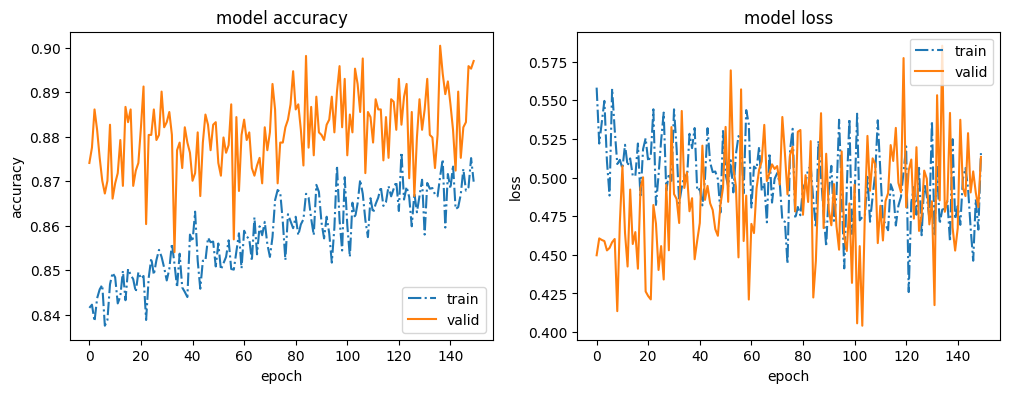

In [0]:
# Anzeige der Entwicklung der Genauigkeit und Loss-function
plt.figure(figsize=(12,4))
plt.subplot(1, 2, (1))
plt.plot(history2.history['accuracy'], linestyle = '-.')
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'lower right')
plt.subplot(1, 2, (2))
plt.plot(history2.history['loss'], linestyle = '-.')
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper right')
plt.show()

In [0]:
score_train2 = model2.evaluate(x_train, y_train, verbose = 0)
print('Trainigsgenauigkeit: ', score_train2[1])

score_test2 = model2.evaluate(x_test, y_test, verbose = 0)
print('Testgenauigkeit: ', score_test2[1])

print('Differenz des Models: ', score_train2[1] - score_test2[1])

Trainigsgenauigkeit:  0.9524695873260498
Testgenauigkeit:  0.8969662189483643
Differenz des Models:  0.05550336837768555


# Modelimplementation - Multilayer Perceptron (MLP) Neural Network mit Keras und Tensorflow mit Kreuzvalidierung nach Folds (10 Stk.)

Nun wird ein CNN als Modell genutzt. Zudem wird wie in der Einleitung beschrieben eine Cross-Validation mit den 10 vordefinierten Fold durchgeführt.

Modell erstellen

In [0]:
num_labels = yy.shape[1]
filter_size = 2
initial_input = 40
output1 = 256
output2 = 256
dropout_rate = 0.5

# Klassenanzahl für Kreuzvalidierung
klassen_anz = 10

# Erstellen des Models
def create_model():
  model = Sequential()

  model.add(Dense(output1, batch_input_shape = (None, initial_input)))
  model.add(Activation('relu'))
  model.add(Dropout(dropout_rate))

  model.add(Dense(output1))
  model.add(Activation('relu'))
  model.add(Dropout(dropout_rate))

  model.add(Dense(num_labels))
  model.add(Activation('softmax'))

  model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

  return model

asdf

In [0]:
le = LabelEncoder()
accuracies = []
num_epochs = 100
num_batch_size = 32

for each_fold in range(1,11): # range für folds 1 - 10
  X_train = np.array(featuresdf[featuresdf["fold"] != each_fold].feature.tolist())
  X_test = np.array(featuresdf[featuresdf["fold"] == each_fold].feature.tolist())
  y_train = np.array(featuresdf[featuresdf["fold"] != each_fold].klasse.tolist())
  y_test = np.array(featuresdf[featuresdf["fold"] == each_fold].klasse.tolist())

  yy_train = to_categorical(le.fit_transform(y_train))
  yy_test = to_categorical(le.fit_transform(y_test))

  # X_train = X_train.reshape(X_train.shape[0], zeilen, spalten, 1) # ohne letzte 1
  # X_test = X_test.reshape(X_test.shape[0], zeilen, spalten, 1) # ohne letzte 1

  model = create_model()

  history = model.fit(X_train, 
                    yy_train, 
                    batch_size = num_batch_size, 
                    epochs = num_epochs,
                    verbose = 0, 
                    validation_data = (X_test, yy_test))

  print("Run ", each_fold)
  score_train = model.evaluate(X_train, yy_train, verbose = 0)
  accuracy_train = 100 * score_train[1]
  print('Training accuracy: %.4f%%' % accuracy_train)
  score_test = model.evaluate(X_test, yy_test, verbose = 0)
  accuracy_test = 100 * score_test[1]
  print('Testing accuracy: %.4f%%' % accuracy_test, '\n')
  accuracies.append(score_test[1])

print("Average Accuracy", np.mean(accuracies))

Run  1
Training accuracy: 93.3961%
Testing accuracy: 49.3700% 

Run  2
Training accuracy: 93.4472%
Testing accuracy: 51.9144% 

Run  3
Training accuracy: 93.7108%
Testing accuracy: 48.0000% 

Run  4
Training accuracy: 93.9163%
Testing accuracy: 51.0101% 

Run  5
Training accuracy: 93.7404%
Testing accuracy: 57.4786% 

Run  6
Training accuracy: 93.5769%
Testing accuracy: 51.0328% 

Run  7
Training accuracy: 93.0580%
Testing accuracy: 55.9666% 

Run  8
Training accuracy: 93.0356%
Testing accuracy: 57.1960% 

Run  9
Training accuracy: 93.5195%
Testing accuracy: 59.1912% 

Run  10
Training accuracy: 94.3382%
Testing accuracy: 55.1971% 

Average Accuracy 0.5363568603992462
